###DRNN Black-Schole model

In [ ]:
import time
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from tensorflow.python.training.moving_averages import assign_moving_average   # moving average
from scipy.stats import multivariate_normal as normal            # Generate normally distributed random numbers
from tensorflow.python.ops import control_flow_ops               #For control flow
from tensorflow import random_normal_initializer as norm_init    #Initializers for generating tensors with normal distributions
from tensorflow import random_uniform_initializer as unif_init   #Generating initializers with uniformly distributed tensors
from tensorflow import constant_initializer as const_init        #Generating initializers for tensors with constant values


# Define an option pricing class
class BS_C(object):


    def __init__ (self,sess,S0,w0):

        self.sess = sess
        self.ww = w0
        self.S0 = S0
        self.M = 10 # 10 assets
        self.d = self.M      # Dimensions of data
        self.T = 20.0/240      # Length of time for each path
        # parameters for the algorithm
        self.dt = 1/240    # Interval of data in each path，delta t = 1/32
        self.n_time = int(self.T/self.dt)
        #self.n_neuron = [self.d ,self.d+10,self.d+10, self.d]
        self.batch_size = 64
        self.valid_size = 64
        self.n_maxstep = 3000
        self.n_displaystep = 50
        self.learning_rate = 0.0008
        self.Yini = [1.2,5]
        # some basic constants and variables
        self.sqrth = math.sqrt(self.dt)
        self.t_stamp = np.arange(0,self.n_time)*self.dt
        self._extra_train_ops = []  # batch moving average operation, which requires additional training of beta and gamma


        self.sigma = 0.1
        self.K = 100
        self.r = 0.03
        self.paths = 10000
        self.epoch_splits = int(self.paths/self.batch_size) - 1

    def train(self):

        start_time = time.time()
        self.global_step = \
            tf.get_variable('global_step', [] ,
                              initializer=tf.constant_initializer(1),
                              trainable=False, dtype=tf.int32)  # Not added to the list of variables to be trained, serves as a step counter
        trainable_vars = tf.trainable_variables()  # Retrieve trainable variables
        grads = tf.gradients(self.loss, trainable_vars)  # Gradients of loss with respect to trainable variables
        optimizer = tf.train.AdamOptimizer(self.learning_rate)  # Gradient optimizer
        apply_op = optimizer.apply_gradients(zip(grads, trainable_vars),  # Apply gradients to update the items in the trainable_vars list
                                              global_step=self.global_step)  # Update both gradients and iteration count

        train_ops = [apply_op] + self._extra_train_ops  # Add operations, akin to list1.extend(list2)
        self.train_op = tf.group(*train_ops)  # tf.group(*train_ops) groups the operations in *train_ops

        self.loss_history = []  # To record loss values
        self.init_history = []  # To record Y0 values

        # For validation, 256 Monte Carlo simulations as the validation set
        dW_valid, X_valid = self.sample_path(self.valid_size)  # Generate data
        feed_dict_valid = {self.dW: dW_valid,  # Feed data to placeholders in buildmodel
                          self.X: X_valid,
                          self.is_training: False}  # Not included in training
        # Initialization
        step = 1
        self.sess.run(tf.global_variables_initializer())  # Initialize all global variables
        # Running the framework, compute loss without training
        temp_loss = self.sess.run(self.loss, feed_dict=feed_dict_valid)  # Compute loss
        temp_init = self.Y0.eval()[0]  # Extract value, Y0 is a 2D tensor
        self.loss_history.append(temp_loss)  # Record loss
        self.init_history.append(temp_init)  # Record Y0
        print("step : %5u, loss : %.3e, " % (0, temp_loss) + "Y0 : % .3e, runtime : %4u " % \
              (temp_init, time.time()-start_time + self.t_bd))


        # Begin SGD iteration, 0-4000 steps
        for i in range(self.n_maxstep + 1):
            step = self.sess.run(self.global_step)
            dW_train, X_train = self.sample_path(self.batch_size)  # Generate data
            self.sess.run(self.train_op,
                          feed_dict={self.dW: dW_train,  # Feed data to placeholders in buildmodel
                                     self.X: X_train,
                                     self.is_training: True})
            if step % self.n_displaystep == 0:  # Every 100 steps, test loss and Y0 values with the validation set
                temp_loss = self.sess.run(self.loss, feed_dict=feed_dict_valid)
                temp_init = self.Y0.eval()  # Extract value, print
                self.loss_history.append(temp_loss)  # Record loss value, output at the end
                self.init_history.append(temp_init)  # Record Y0 value, Y0 is a 2D tensor
                print("step: %5u, loss: %.3e, " % \
                      (step, temp_loss) + \
                      "Y0: % .3e, runtime: %.3e " % \
                      (temp_init, time.time() - start_time + self.t_bd))
            step += 1
        end_time = time.time()  # Total time at the end of training
        print("running time: %.3f s " % \
              (end_time - start_time + self.t_bd))


    def build(self):
        '''build the whole network by stacking subnetworks，构架大网络'''
        start_time = time.time ()
        self.dW = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time] ,name = 'dW')
        self.X = tf.placeholder(tf.float64 ,[ None , self.d , self.n_time+1] ,name = 'X')
        self.is_training = tf.placeholder (tf.bool)

        # initializationY0\Z0
        self.Y0 = tf.Variable(tf.random_uniform([1],
                            minval = self.Yini [0] ,
                            maxval = self.Yini [1] ,
                            dtype = tf.float64 ));
        self.Z0 = tf.Variable (tf.random_uniform ([1,self.d] ,
                            minval = -.1 ,
                            maxval =.1 ,
                            dtype = tf.float64 ))
        self.allones = tf.ones(shape = tf.stack([tf.shape(self.dW)[0],1]) ,   # tf.shape(self.dW)[0]=len(batch),shape=(batch,1)
                         dtype = tf.float64 )


        Y = self.allones * self.Y0
        Z = tf.matmul(self.allones, self.Z0 )

        ww =tf.constant(self.ww,shape=(self.M,1))   # Customized weights
        with tf.variable_scope('forward',reuse = tf.AUTO_REUSE):
            cell = tf.nn.rnn_cell.BasicRNNCell(num_units=self.d+10)
            hid = cell.zero_state(tf.shape(self.X[:,:,0])[0],tf.float64)
            w = tf.get_variable('Matrixhid',
                                        [self.d+10, self.d] ,tf.float64,
                                        norm_init(stddev = \
                                                  5 / np.sqrt(2*self.d+10)))
            for t in range(self.n_time-1):  # The first N-2 xt of the network
                    Y = self.f_tf(self.t_stamp[t],Y,Z,self.X[:,:,t],self.dW[:,:,t])
                    output,hid = cell(self.X[:,:,t+1],hid)
                    Z = tf.nn.relu(tf.matmul(output ,w))

            # terminal time
            Y = self.f_tf(self.t_stamp[self.n_time-1] ,Y,Z,self.X[:,:, -2],self.dW[:,:, -1])
            Yw = tf.matmul(Y,ww)
            term_delta = Yw - self.g_tf(self.T,
                                   self.X[:,:,-1],ww) # Loss function formula
            self.clipped_delta = tf.clip_by_value(term_delta ,-50.0 , 50.0)
            self.loss = tf.reduce_mean(self.clipped_delta**2)#Calculate the loss
        self.t_bd = time.time() - start_time  # Time to generate network


    def sample_path(self, n_sample):
        # Generate paths, producing (xt, (wt-wt-1))
        dW_sample = np.zeros([n_sample, self.d, self.n_time])  # Number of samples, dimensions, time length
        X_sample = np.zeros([n_sample, self.d, self.n_time + 1])
        X_sample[:, :, 0] = self.S0  # Set initial asset prices
        for i in range(self.n_time):  # Generate one column at a time, up to T=20
            dW_sample[:, :, i] = \
              np.reshape(normal.rvs(mean=np.zeros(self.d),  # This function is equivalent to np.random.normal()
                                    cov=1,  # Why not std=1?
                                    size=n_sample) * self.sqrth,  # Square root of delta t, W(t)-W(s) independent of W(r), and has mean 0 and variance t-s
                          (n_sample, self.d))
            X_sample[:, :, i + 1] = X_sample[:, :, i] + \
                                  self.r * X_sample[:, :, i] * self.dt + self.sigma * X_sample[:, :, i] * dW_sample[:, :, i]
        return dW_sample, X_sample



    def f_tf(self,t,Y,Z,X,dW):

        f = tf.reshape((Z*self.sigma*X)*dW,shape=(-1,self.M))
        return Y+self.r*Y*self.dt+f
    def g_tf(self,t,X,ww):
        # terminal conditions
        return tf.matmul(tf.nn.relu(X-self.K),ww)

    def _batch_norm(self, x, name):
        '''Perform batch normalization on the input data, returns the processed data with the same shape as the input.'''
        with tf.variable_scope(name):
            params_shape = [x.get_shape()[-1]]  # [d,d+10,d+10,d], the first dimension is batch
            beta = tf.get_variable('beta', params_shape,
                                        tf.float64,
                                        norm_init(0.0, stddev=0.1,  # Normal distribution random numbers
                                        dtype=tf.float64))
            gamma = tf.get_variable('gamma', params_shape,
                                        tf.float64,
                                        unif_init(0.1, 0.5,  # Uniform distribution random numbers
                                        dtype=tf.float64))
            mv_mean = tf.get_variable('moving_mean',  # As each batch is different, use moving_mean to improve the mean
                                        params_shape,
                                        tf.float64,
                                        const_init(0.0, tf.float64),  # Initialized to 0
                                        trainable=False)
            mv_var = tf.get_variable('moving_variance',
                                        params_shape,
                                        tf.float64,
                                        const_init(1.0, tf.float64),  # Initialized to 1
                                        trainable=False)

            # These operations will only be performed when training
            mean, variance = tf.nn.moments(x, [0], name='moments')  # Dimensions to normalize around the center, [0] indicates batch, calculate mean and variance for 64 data points
            self._extra_train_ops.append(
                assign_moving_average(mv_mean, mean, 0.99))  # Explanation below
            self._extra_train_ops.append(
                assign_moving_average(mv_var, variance, 0.99))

            mean, variance = \
                control_flow_ops.cond(self.is_training,  # control_flow_ops.cond controls the execution flow, the first argument is the condition
                                    lambda: (mean, variance),  # If condition is True, execute during training, need to recalculate mean and variance
                                    lambda: (mv_mean, mv_var))  # If condition is False, execute during testing, directly use the last smoothed values


            y = tf.nn.batch_normalization (x , mean , variance ,
                                           beta , gamma , 1e-6)

            y.set_shape(x.get_shape())
            return y

def main(name, S0, w):
    tf.reset_default_graph()  # Reset the default graph
    with tf.Session() as sess:
        tf.set_random_seed(1)  # Set random seed for TensorFlow
        print("B-S equation")  # Black-Scholes equation
        model = BS_C(sess, S0, w)  # Create an object
        model.build()  # Call object method to build a model, defines the solutions but does not pass data
        model.train()  # Generate and pass data to build
        output = np.zeros((len(model.init_history), 3))  # Initialize results to zero, to be filled later
        output[:, 0] = np.arange(len(model.init_history)) * model.n_displaystep  # Output steps
        output[:, 1] = model.loss_history  # Output loss list
        output[:, 2] = model.init_history  # Output Y0 list
        np.savetxt("./MBS_" + str(name) + ".csv",  # Save output results
                   output,
                   fmt=['%d', '%.5e', '%.5e'],
                   delimiter=",",
                   header="step,loss function, target value",
                   comments='')  # No comments in the header
    return output

S0_w = pd.read_excel('./BS_S0_w.xlsx')
S0 = S0_w.S0
w = S0_w.w2  # w = S0_w.w not averaged, w2 averaged
if __name__ == '__main__':
    np.random.seed(1)  # Set a random number seed
    for i in range(5):
        print(str(i) + ' run:')
        output = main(i, S0, w)  # Run the main program


0 run:
 B-S equation 
Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
step :     0 , loss : 1.574e+00 , Y0 :  1.842e+00 , runtime :    3 
step :    50 , loss : 7.919e-01 ,  Y0 :  1.822e+00 , runtime : 5.363e+00 
step :   100 , loss : 4.340e-01 ,  Y0 :  1.801e+00 , runtime : 5.968e+00 
step :   150 , loss : 3.001e-01 ,  Y0 :  1.790e+00 , runtime : 6.513e+00 
step :   200 , loss : 2.663e-01 ,  Y0 :  1.782e+00 , runtime : 7.066e+00 
step :   250 , loss : 2.600e-01 ,  Y0 :  1.775e+00 , runtime : 7.551e+00 
step :   300 , loss : 2.597e-01 ,  Y0 :  1.769e+00 , runtime : 8.068e+00 
st

step :  1550 , loss : 1.940e-01 ,  Y0 :  1.754e+00 , runtime : 1.946e+01 
step :  1600 , loss : 1.941e-01 ,  Y0 :  1.753e+00 , runtime : 1.996e+01 
step :  1650 , loss : 1.949e-01 ,  Y0 :  1.753e+00 , runtime : 2.057e+01 
step :  1700 , loss : 2.033e-01 ,  Y0 :  1.756e+00 , runtime : 2.124e+01 
step :  1750 , loss : 1.946e-01 ,  Y0 :  1.758e+00 , runtime : 2.186e+01 
step :  1800 , loss : 1.960e-01 ,  Y0 :  1.760e+00 , runtime : 2.248e+01 
step :  1850 , loss : 1.940e-01 ,  Y0 :  1.757e+00 , runtime : 2.304e+01 
step :  1900 , loss : 1.965e-01 ,  Y0 :  1.758e+00 , runtime : 2.367e+01 
step :  1950 , loss : 1.923e-01 ,  Y0 :  1.762e+00 , runtime : 2.429e+01 
step :  2000 , loss : 1.984e-01 ,  Y0 :  1.754e+00 , runtime : 2.484e+01 
step :  2050 , loss : 1.959e-01 ,  Y0 :  1.761e+00 , runtime : 2.542e+01 
step :  2100 , loss : 1.936e-01 ,  Y0 :  1.761e+00 , runtime : 2.597e+01 
step :  2150 , loss : 1.952e-01 ,  Y0 :  1.758e+00 , runtime : 2.650e+01 
step :  2200 , loss : 2.008e-01 ,  Y0 

step :   950 , loss : 2.158e-01 ,  Y0 :  1.760e+00 , runtime : 1.351e+01 
step :  1000 , loss : 2.163e-01 ,  Y0 :  1.765e+00 , runtime : 1.401e+01 
step :  1050 , loss : 2.154e-01 ,  Y0 :  1.755e+00 , runtime : 1.452e+01 
step :  1100 , loss : 2.130e-01 ,  Y0 :  1.757e+00 , runtime : 1.507e+01 
step :  1150 , loss : 2.125e-01 ,  Y0 :  1.762e+00 , runtime : 1.562e+01 
step :  1200 , loss : 2.124e-01 ,  Y0 :  1.770e+00 , runtime : 1.620e+01 
step :  1250 , loss : 2.119e-01 ,  Y0 :  1.775e+00 , runtime : 1.671e+01 
step :  1300 , loss : 2.110e-01 ,  Y0 :  1.763e+00 , runtime : 1.723e+01 
step :  1350 , loss : 2.129e-01 ,  Y0 :  1.755e+00 , runtime : 1.778e+01 
step :  1400 , loss : 2.139e-01 ,  Y0 :  1.759e+00 , runtime : 1.832e+01 
step :  1450 , loss : 2.096e-01 ,  Y0 :  1.759e+00 , runtime : 1.885e+01 
step :  1500 , loss : 2.083e-01 ,  Y0 :  1.753e+00 , runtime : 1.934e+01 
step :  1550 , loss : 2.075e-01 ,  Y0 :  1.758e+00 , runtime : 1.986e+01 
step :  1600 , loss : 2.085e-01 ,  Y0 

### Visualization of statistical results

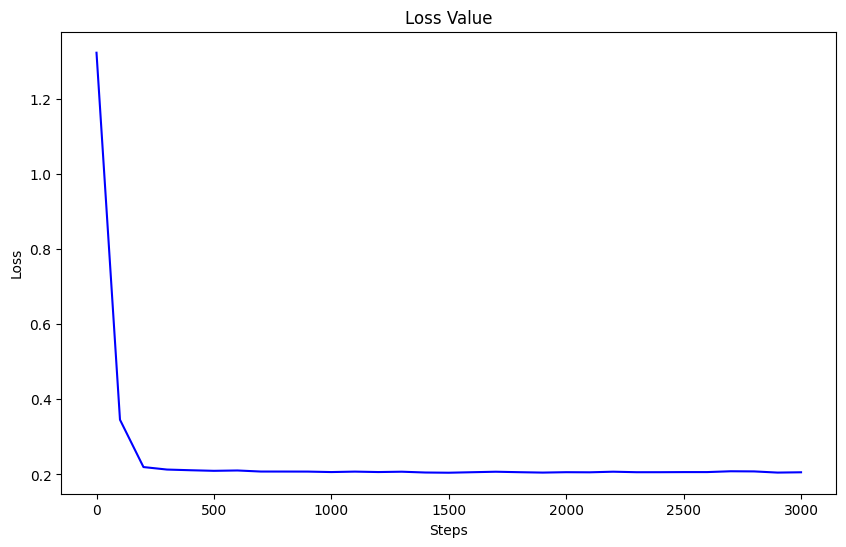

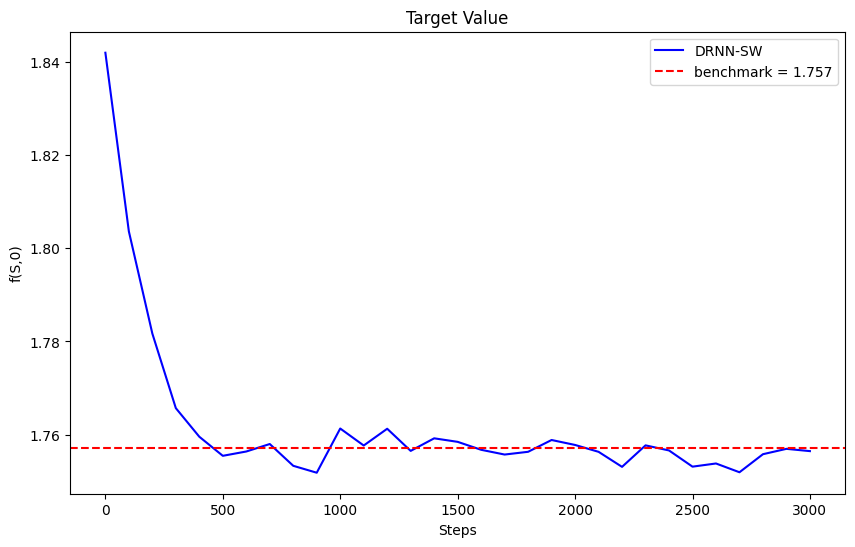

In [18]:
import matplotlib.pyplot as plt
data = pd.read_excel('./mbs_data.xlsx',)

# Plot the mean loss over steps
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['Mean_loss'], linestyle='-', color='b')
plt.title('Loss Value')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

# Replotting the mean target value with the constant line
plt.figure(figsize=(10, 6))
plt.plot(data['step'], data['Mean_Y0'], label='DRNN-SW', color='blue')
plt.axhline(y=1.7570374674616598, color='red', linestyle='--', label='benchmark = 1.757')
plt.title('Target Value')
plt.xlabel('Steps')
plt.ylabel('f(S,0)')
plt.legend()
plt.show()

